### Multiple Agents RAG Network

#####  Purpose: 
To create a blog generation model, using 2 agents (researcher, content_writer)
* researcher: for a researcher agent we will be using retriever tool
* content_writer: for content writer we will be using tavily web search tool

In [5]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from langchain.agents import create_agent

from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain.tools import tool

from langchain_tavily import TavilySearch

from langchain_core.messages import BaseMessage, HumanMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from typing import Annotated, Literal
from langgraph.types import Command



load_dotenv()

os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

#base model

model = init_chat_model(model="groq:llama-3.1-8b-instant")

In [6]:
#node navigation cutsom function

def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # agent decided the work is done
        return END
    return goto

#system prompt custom function

def make_system_prompt(suffix:str) -> str:
    return (f"""
            You are a helpful AI assistant, collaborating with other assistants.
            Use the provided tools to progress towards answering the question.
            If you are unable to fully answer, that's ok, another assistant with different tools will
            help where you left out. Execute what you can to make progress
            If you or any other assistants have the final answer or deliverables,
            prefix your response with FINAL ANSWER so the team knows to stop
            \n {suffix}""")

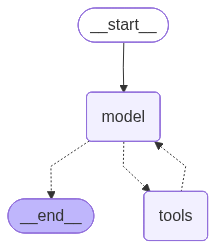

In [7]:
#researcher agent with rag tools
def get_retrieved_file_docs(filepath:str, query:str)->List[Document]:
    "based on given query, this function retrieves relevant documents from given filepath location"
    documents = TextLoader(filepath, encoding='utf-8').load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50).split_documents(documents)
    retriever = FAISS.from_documents(
        documents=chunks,
        embedding=HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
    ).as_retriever()
    relevant_docs = retriever.invoke(query)
    return relevant_docs

@tool(description='this tool retrieves relevant docs from "./chatgpt_notes.txt" file')
def gpt_docs(filepath, query):
    return get_retrieved_file_docs(filepath, query)

@tool(description='this tool retrieves relevant docs from "./llama_notes.txt" file')
def llama_docs(filepath, query):
    return get_retrieved_file_docs(filepath, query)


researcher_agent=create_agent(model = model, tools=[gpt_docs, llama_docs],
                              system_prompt=make_system_prompt(suffix="""
           You are a researcher agent,your task is to generate blogs based on given question.
        You have a content_write agent colleague"""))
researcher_agent


In [8]:
# #testing researcher agent
# q="what are chatgpt limitations"

# researcher_agent.invoke({"messages":{"role":"user", "content":q}})

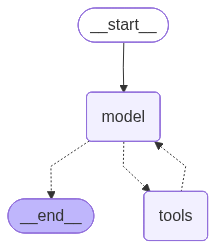

In [9]:
#content writer agent with tavily tool binded agent

tool_tavily = TavilySearch(max_results=2)

tool = [tool_tavily]

writer_agent = create_agent(model=model,
                            tools=tool,
                            system_prompt=make_system_prompt(suffix="""
                                You are content writer agent, 
                                your task is to collaborate with researcher agant and generate blog.""")
                            )

writer_agent

In [10]:
# #testing content_writer agent
# q="what is genai"

# writer_agent.invoke({"messages":{"role":"user", "content":q}})

In [11]:
#defining nodes functions
#researcher node:

class MultiAgentState(BaseModel):
    messages: Annotated[List, add_messages]
    

def researcher_node(state:MultiAgentState)->Command[Literal['content_writer_node', END]]:
    research_result = researcher_agent.invoke(state)
    val = research_result['messages'][-1]

    #passing this to HumanMessage, since not all agent provider accept AIMessage as input
    research_result['messages'][-1 ]= HumanMessage(content=val.content, name="researcher")

    go_to = get_next_node(last_message=val, goto="content_writer_node")

    return Command(
        update={
            "messages": research_result['messages']

        },
        goto=go_to

    )



In [12]:
def content_writer_node(state:MultiAgentState)->Command[Literal['researcher_node', END]]:
    writer_result = writer_agent.invoke(state)
    writer_val = writer_result['messages'][-1]

    #passing this to HumanMessage, since not all agent provider accept AIMessage as input
    writer_result['messages'][-1 ]= HumanMessage(content=writer_val.content, name="content_writer")

    go_to = get_next_node(last_message=writer_val, goto="researcher_node")

    return Command(
        update={
            "messages": writer_result['messages']

        },
        goto=go_to

    )

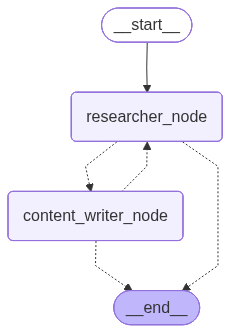

In [13]:
#defining graph workflow

graph = StateGraph(MultiAgentState)

graph.add_node("researcher_node", researcher_node)
graph.add_node("content_writer_node", content_writer_node)

graph.add_edge(START, "researcher_node")

graph_builder = graph.compile()

graph_builder

In [14]:
query="what is generative ai agents, say about chatgpt and llama models"
state = MultiAgentState(messages=[query])

result = graph_builder.invoke(state)
result


{'messages': [HumanMessage(content='what is generative ai agents, say about chatgpt and llama models', additional_kwargs={}, response_metadata={}, id='937155e8-f4a0-43e0-9b80-d1be7d9a8d35'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'd8yh92hp2', 'function': {'arguments': '{"filepath":"./chatgpt_notes.txt","query":"generative ai agents"}', 'name': 'gpt_docs'}, 'type': 'function'}, {'id': 'j2g9e70d5', 'function': {'arguments': '{"filepath":"./llama_notes.txt","query":"generative ai agents"}', 'name': 'llama_docs'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 438, 'total_tokens': 521, 'completion_time': 0.200027702, 'completion_tokens_details': None, 'prompt_time': 0.028449262, 'prompt_tokens_details': None, 'queue_time': 0.066356898, 'total_time': 0.228476964}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': No

In [16]:
print(result['messages'][-1].content)

FINAL ANSWER

**Generative AI Agents: A New Era of Artificial Intelligence**

The world of artificial intelligence has witnessed a significant transformation in recent years, with the emergence of generative AI agents. These agents have the ability to perform tasks such as generating text, speech, and images in response to user prompts, revolutionizing the way we interact with machines. In this blog, we will delve into the world of generative AI agents, exploring their capabilities, and discussing the impact they are set to have on various industries.

**What are Generative AI Agents?**

Generative AI agents are a type of artificial intelligence that uses generative pre-trained transformers (GPTs) to generate responses to user prompts. These agents are trained on vast amounts of data, allowing them to learn patterns and relationships within the data, and generate new, coherent, and contextually relevant responses.

**ChatGPT: A Pioneer in Generative AI**

ChatGPT, developed by OpenAI, 